In [390]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
import seaborn as sns
from plotnine import *


import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.stats as stats


from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings("ignore")

In [391]:
#reading data
axis=pd.read_csv(r"C:\Users\RAHUL KUMAR\Downloads\axisbank(2023-24).csv")

In [392]:
axis.head()


,Date,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades
0,29-Dec-2023,EQ,"1,101.45","1,106.85","1,093.95","1,107.85","1,100.10","1,102.30","1,100.75","1,151.85",814.3,"87,86,731","9,67,19,68,618.40","2,40,614"
1,28-Dec-2023,EQ,"1,107.25","1,113.00","1,098.00","1,106.35","1,105.45","1,107.85","1,106.86","1,151.85",814.3,"1,40,97,667","15,60,41,86,879.50","2,45,184"
2,27-Dec-2023,EQ,"1,096.05","1,110.55","1,089.65","1,094.25","1,105.15","1,106.35","1,098.80","1,151.85",814.3,"61,32,936","6,73,88,56,890.50","1,76,530"
3,26-Dec-2023,EQ,"1,091.20","1,100.65","1,086.70","1,088.30","1,095.10","1,094.25","1,095.43","1,151.85",814.3,"56,87,517","6,23,02,84,824.95","1,72,889"
4,22-Dec-2023,EQ,"1,095.40","1,106.30","1,085.80","1,095.40","1,087.00","1,088.30","1,096.23","1,151.85",814.3,"1,06,00,025","11,62,01,11,915.20","2,18,277"


In [393]:
axis = axis[['Date ', 'OPEN ', 'HIGH ', 'LOW ',"close ","VOLUME "]]
axis.columns = ['Date', 'Open', 'High', 'Low',"Close","Volume"]

In [394]:
axis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495 entries, 0 to 494
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    495 non-null    object
 1   Open    495 non-null    object
 2   High    495 non-null    object
 3   Low     495 non-null    object
 4   Close   495 non-null    object
 5   Volume  495 non-null    object
dtypes: object(6)
memory usage: 23.3+ KB


We need to change the Date column as index and as Datetime format

In [395]:
axis["Date"]=pd.to_datetime(axis['Date'])

In [396]:
axis.set_index("Date",inplace=True)

In [397]:
axis.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2024-01-05,"1,124.00","1,139.90","1,119.00","1,136.95","80,25,466"
2024-01-04,"1,103.00","1,130.00","1,100.05","1,123.40","1,14,11,683"
2024-01-03,"1,091.00","1,102.60","1,081.30","1,098.60","1,02,25,290"
2024-01-02,"1,095.10","1,099.35","1,082.30","1,093.25","78,95,577"
2024-01-01,"1,095.00","1,104.00","1,093.00","1,097.70","40,83,732"


We have the data from 2023 to 2024.

`Also we can clearly observe that currently data is ordered in wrong format`

- Lets correct the datatype of other columns

In [398]:
axis[["Open", "High", "Low", "Close", "Volume"]] = (
    axis[["Open", "High", "Low", "Close", "Volume"]]
    .replace({",": ""}, regex=True)  # Remove commas
    .apply(pd.to_numeric, errors="coerce")  # Convert to numeric
)

In [399]:
axis.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 495 entries, 2023-12-29 to 2024-01-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    495 non-null    float64
 1   High    495 non-null    float64
 2   Low     495 non-null    float64
 3   Close   495 non-null    float64
 4   Volume  495 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 23.2 KB


**Correcting the order of Data**

In [400]:
axis = pd.concat((axis.iloc[245::-1],axis.iloc[:245:-1]),axis = 0)
axis

,Open,High,Low,Close,Volume
Date,,,,,
2023-01-02,932.25,945.00,931.80,941.60,3498198
2023-01-03,944.75,965.60,942.60,962.30,6927819
2023-01-04,963.50,970.00,955.00,957.45,9059392
2023-01-05,960.00,961.90,938.25,949.55,6998980
2023-01-06,946.55,950.95,934.30,939.90,5787783
...,...,...,...,...,...
2024-12-24,1077.30,1084.75,1076.00,1078.90,4343694
2024-12-26,1083.00,1092.60,1072.75,1076.70,4775460
2024-12-27,1078.10,1086.25,1076.00,1077.45,3801667


We can clearly see we have certain gaps in between i.e we have data of **mon-fri** only

In [401]:
axis[axis.isnull().any(axis=1)]

,Open,High,Low,Close,Volume
Date,,,,,


we have no missing value

**Lets look at descriptive statistics of Closing price and opening price**

In [402]:
axis[["Close","Open"]].describe(percentiles = [0.1,0.25,0.5,0.75,0.9,0.99,1])

,Close,Open
count,495.000000,495.000000
mean,1050.625758,1051.039192
std,120.820582,120.821062
min,824.050000,821.500000
10%,868.570000,871.910000
25%,959.325000,960.000000
50%,1059.100000,1056.250000
75%,1147.700000,1150.000000
90%,1187.120000,1191.300000
99%,1292.614000,1300.063000


In [403]:
print("Skewness of closing price:",stats.skew(axis.Close))
print("Skewness of openinng price:",stats.skew(axis.Open))
print("kurtosis of closing price:",stats.kurtosis(axis.Close))
print("kurtosis of opening price:",stats.kurtosis(axis.Open))




Skewness of closing price: -0.024957325617124146
Skewness of openinng price: -0.01456983843707794
kurtosis of closing price: -0.9105725111285023
kurtosis of opening price: -0.9184356036736827


Looking at these description we can say that our data have no potential outliers as such and also we have both the  skewness and kurtosis values negative

## Visualizing Time Series

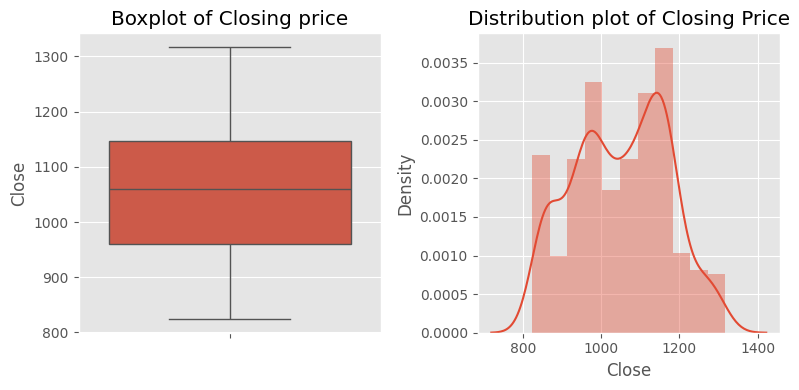

In [404]:
plt.figure(figsize = (8,4))
plt.subplot(1,2,1)
plt.title("Boxplot of Closing price")
sns.boxplot(axis.Close)
plt.subplot(1,2,2)
sns.distplot(axis.Close)
plt.title("Distribution plot of Closing Price")
plt.tight_layout()
plt.show()


As stated earlier, there are no outliers visible in boxplot and distribution plot shows peak at two places 

**Lets plot the time series**

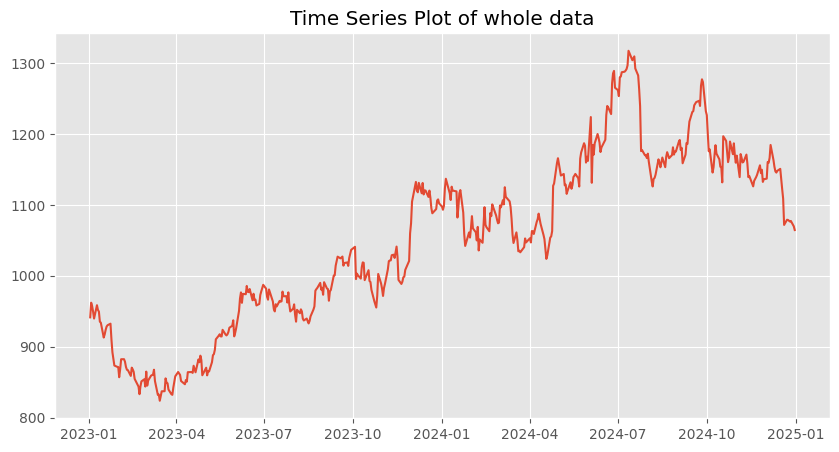

In [405]:
plt.figure(figsize=(10,5))
plt.plot(axis.Close)
plt.title("Time Series Plot of whole data")
plt.show()

**Definetely there is upward trend and also some ambigious periodicity can be present and also the time series is not stationary**

**Lets plot the time series plot yearly**

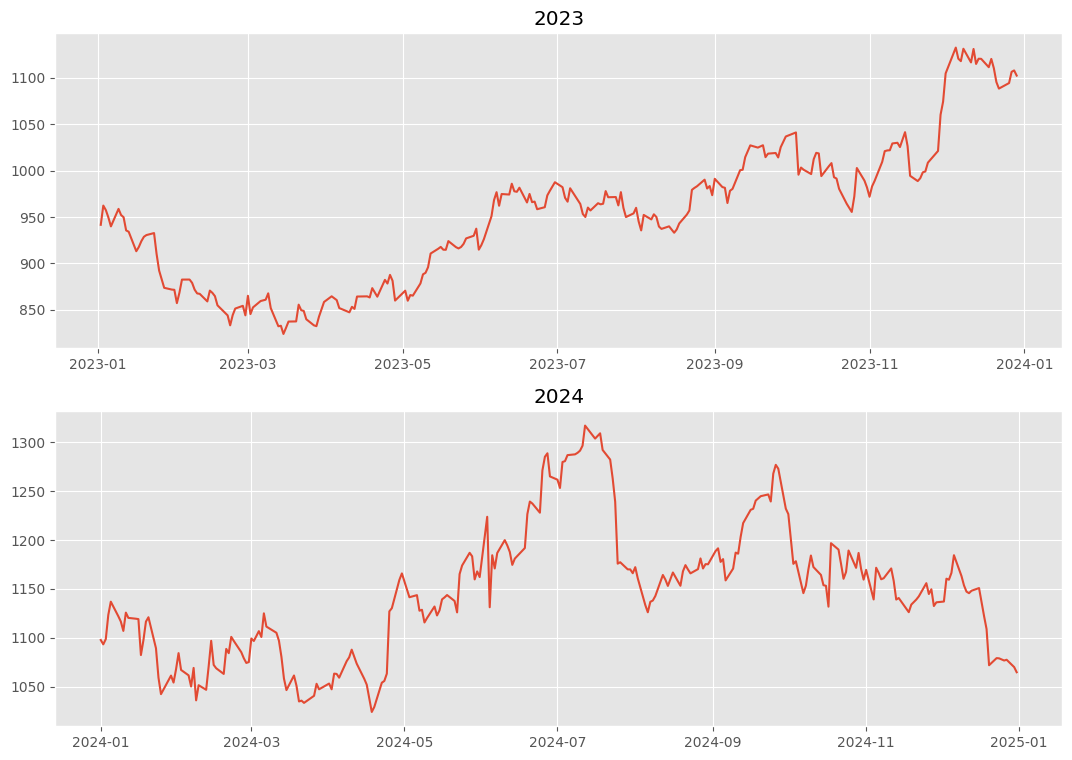

In [406]:
fig,axes=plt.subplots(nrows=2,ncols=1,figsize=(13,9))

axes=axes.ravel()

axes[0].plot(axis.Close[:246])
axes[0].set_title("2023")

axes[1].plot(axis.Close[246:])
axes[1].set_title("2024")

plt.show()


    

As per these yearly plots, we cannot see any general yearly pattern in the data

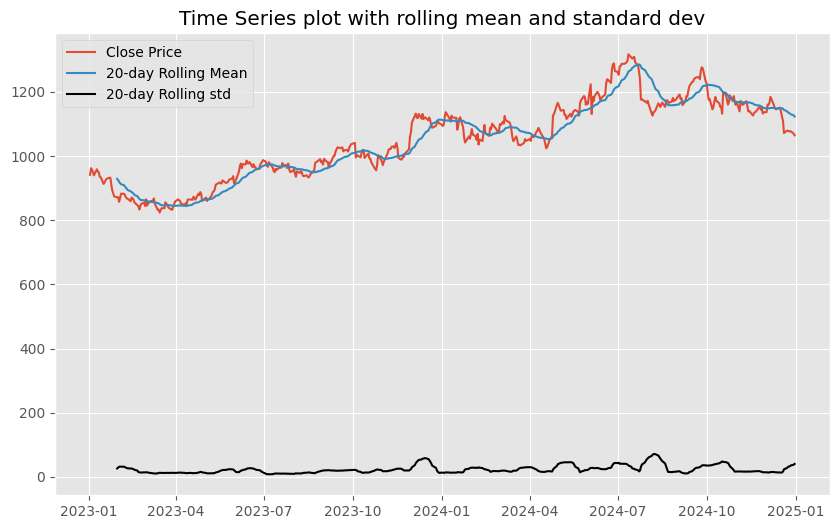

In [407]:


plt.figure(figsize=(10, 6))
plt.plot(axis['Close'], label='Close Price')
plt.plot(axis['Close'].rolling(window=20).mean(), label='20-day Rolling Mean')

plt.plot(axis['Close'].rolling(window=20).std(), label='20-day Rolling std',color="black")
plt.title("Time Series plot with rolling mean and standard dev")

plt.legend()
plt.show()

**Lets try seasonal decomposition**

## we will perform Seasonal Decomposition

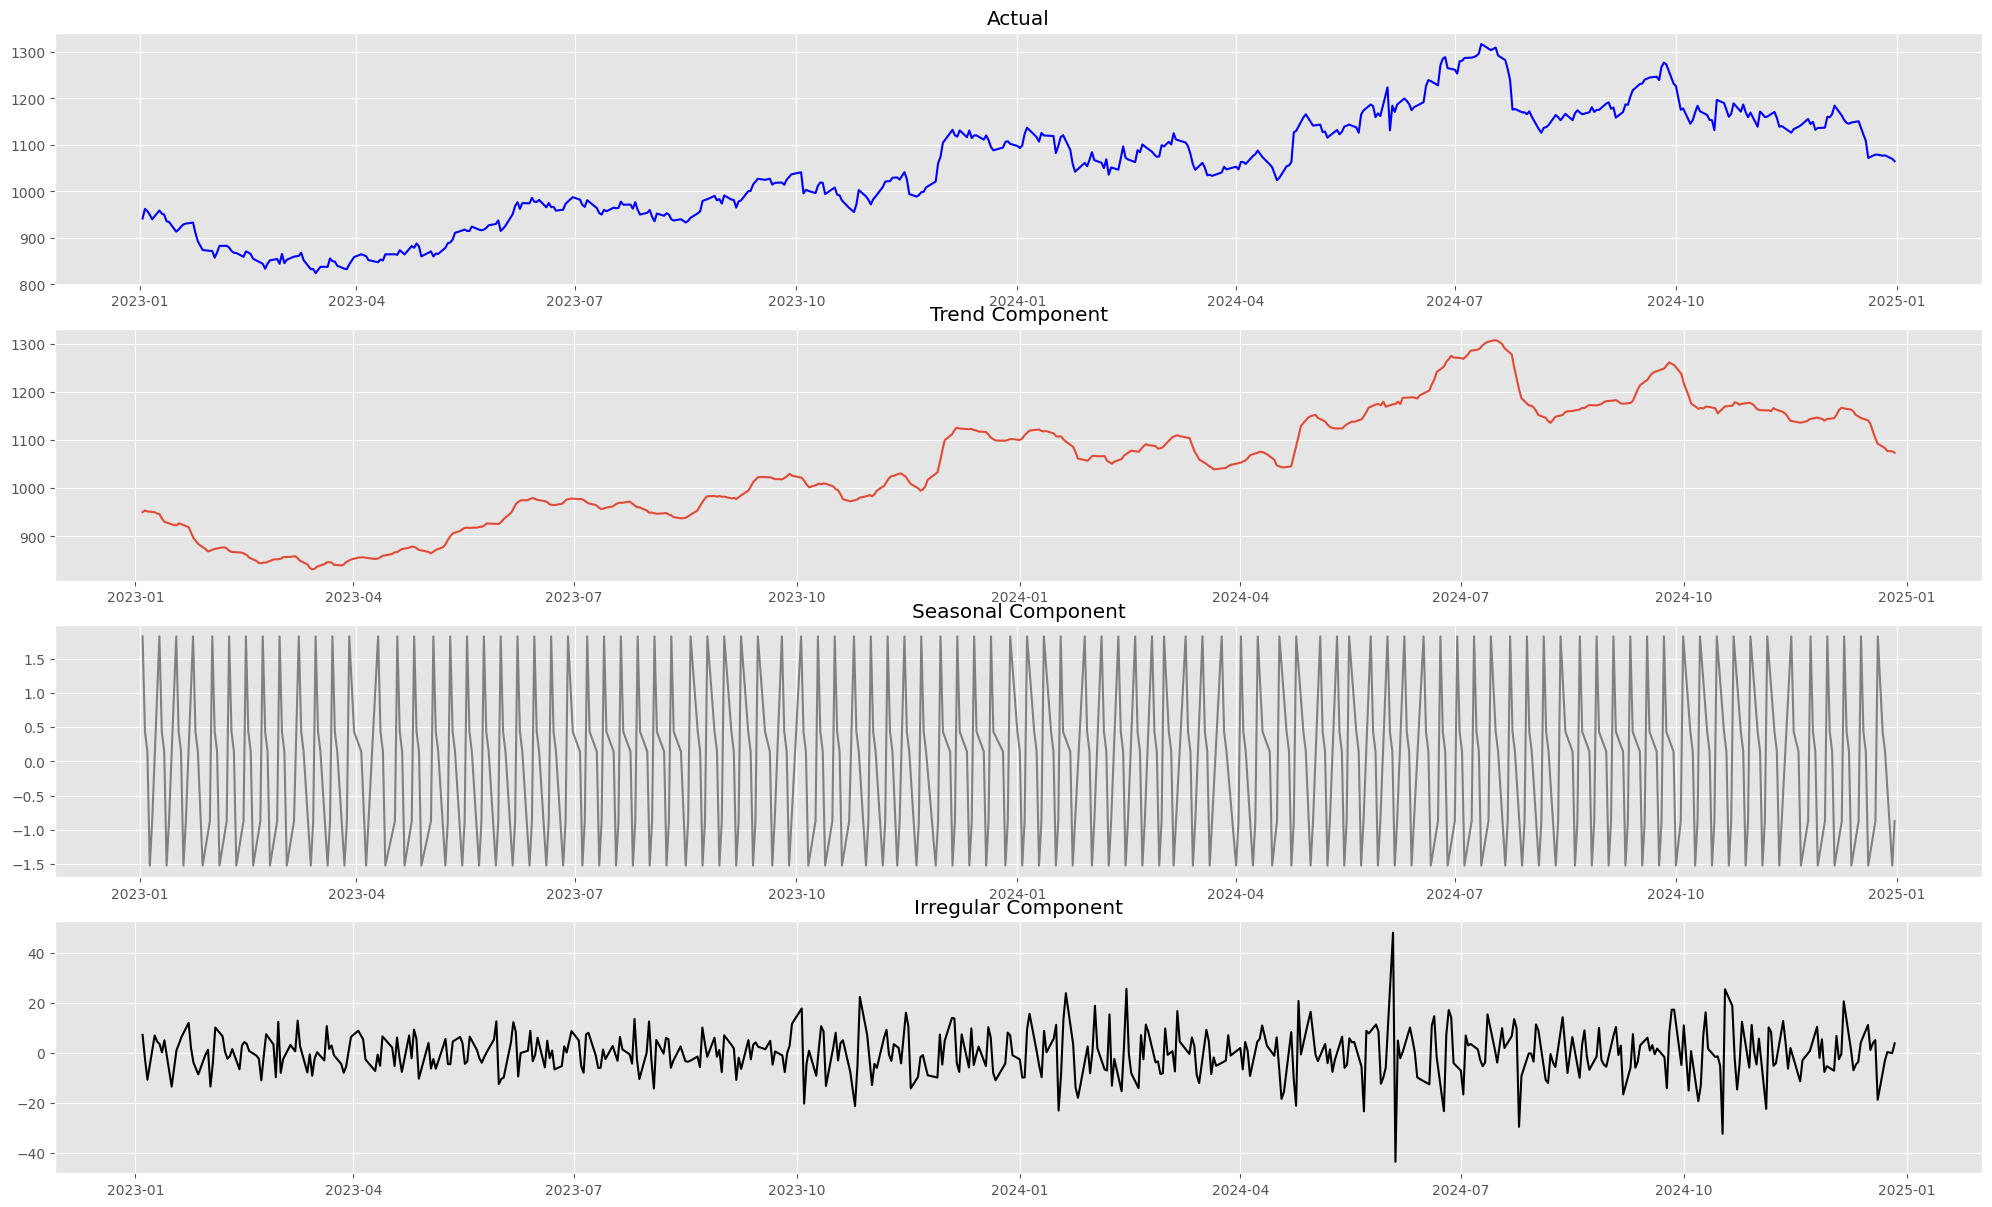

In [408]:
from statsmodels.tsa.seasonal import seasonal_decompose

dec=seasonal_decompose(axis["Close"],model="additive",period = 5)

fig,axes=plt.subplots(4,1,figsize=(20,12))

plt.tight_layout()
axes[0].plot(dec.observed,color='blue')
axes[0].set_title("Actual")

axes[1].plot(dec.trend)
axes[1].set_title("Trend Component")

axes[2].plot(dec.seasonal,color='grey')
axes[2].set_title("Seasonal Component")

axes[3].plot(dec.resid,color='black')
axes[3].set_title("Irregular Component")

plt.show()


- From these plots, we can clearly see upward trend till 2015 and then our time series stablizes.
-  The seasonal component appears regular with a consistent pattern over the years, indicating strong periodic affect
-  There are significant spikes between 2015 and 2016, suggesting anomalies during that period

**Lets look at seasonal component by zooming in**

`With period 5`

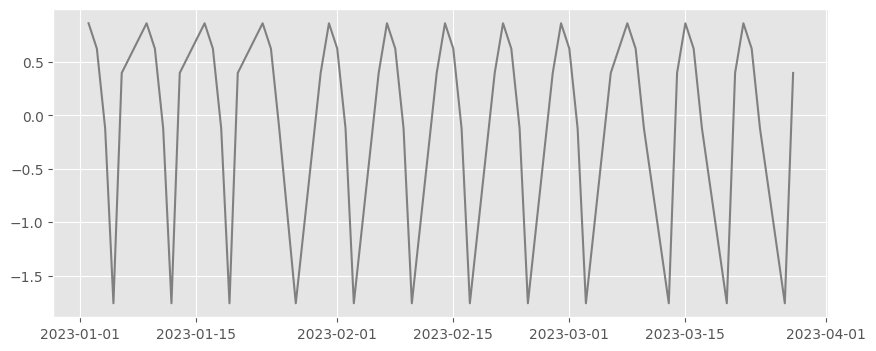

In [409]:
plt.figure(figsize = (10,4))
dec=seasonal_decompose(axis["Close"][:60],model="additive",period = 5)
plt.plot(dec.seasonal,color='grey')

`with period of 14`

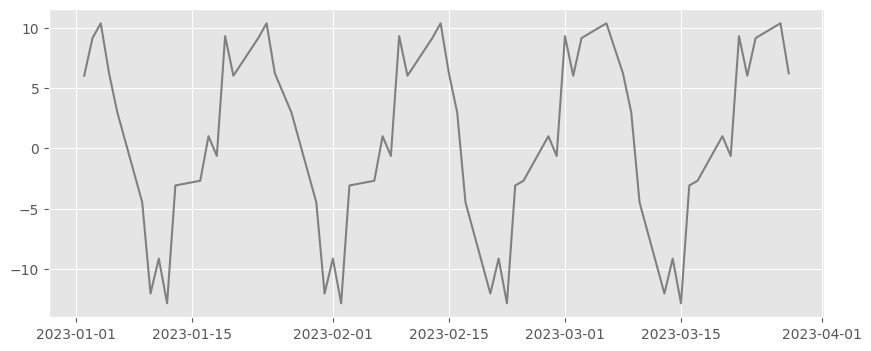

In [410]:
plt.figure(figsize = (10,4))
dec=seasonal_decompose(axis["Close"][:60],model="additive",period = 14)
plt.plot(dec.seasonal,color='grey')

There is some consistent periodicity in the data 

**Lets visualize daily return to analyze the percentage change**

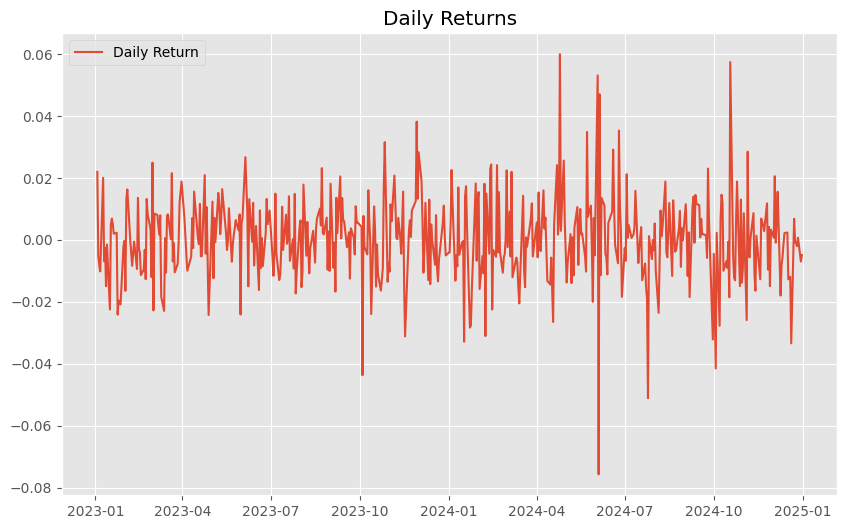

In [411]:
axis['daily_return'] = axis['Close'].pct_change()
plt.figure(figsize=(10, 6))
plt.plot(axis['daily_return'], label='Daily Return')
plt.title('Daily Returns')
plt.legend()
plt.show()

**Analyze the spread between daily high and low prices**

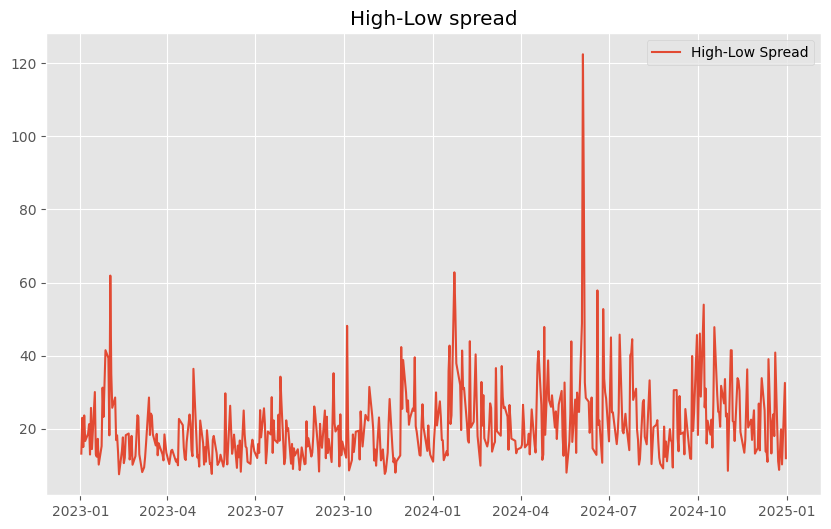

In [412]:
axis['high_low_spread'] = axis['High'] - axis['Low']
plt.figure(figsize=(10, 6))
plt.plot(axis['high_low_spread'], label='High-Low Spread')
plt.title("High-Low spread")
plt.legend()
plt.show()

There are some high spike in few days (especially in 6th month of 2024)

## `Argumented Dickey-Fuller Test(ADF)`

**ADF** is unit root test which test for the presence of unit root in  time series.

`Unit Root`: unit root is a characteristics of time series which makes it unstable

- **Null Hypothesis Ho** Series is non-stationary. and there is presence of unit root.

- **Alternate Hypothesis H1** The time series has no unit root and is either stationary or can be made stationary using differencing.


In [413]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(axis['Close'])
print('ADF Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(adf_test[0], adf_test[1], adf_test[2]))
for key, value in adf_test[4].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))


ADF Statistic: -1.455649
p-value: 0.555326
#Lags used: 3
Critical Value (1%): -3.443739
Critical Value (5%): -2.867444
Critical Value (10%): -2.569915


P-value: **0.555** is quite large giving support to null hypothesis that series is not stationary which was expected as our data has upward trend

# Autocorrelation function and Partial autocorrelation function

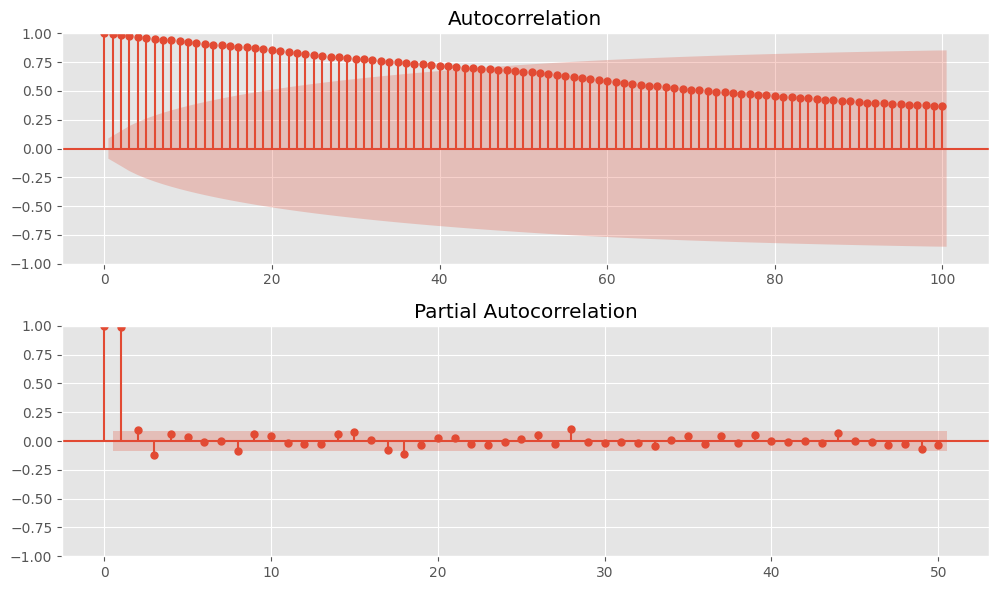

In [414]:
#Plotting auto correlation and partial correlation

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(axis["Close"], lags=100, ax=ax1)
plot_pacf(axis["Close"], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

# Models Fitting

- We will try ARIMA model and SARIMA model as we have seen that model is not stationary
- We will use differencing of one

**`ARIMA Model`**

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  470
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1935.425
Date:                Sun, 02 Feb 2025   AIC                           3874.850
Time:                        22:37:40   BIC                           3883.151
Sample:                             0   HQIC                          3878.116
                                - 470                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0952      0.031     -3.107      0.002      -0.155      -0.035
sigma2       224.8662      8.880     25.322      0.000     207.461     242.271
Ljung-Box (L1) (Q):                   0.06   Jarque-

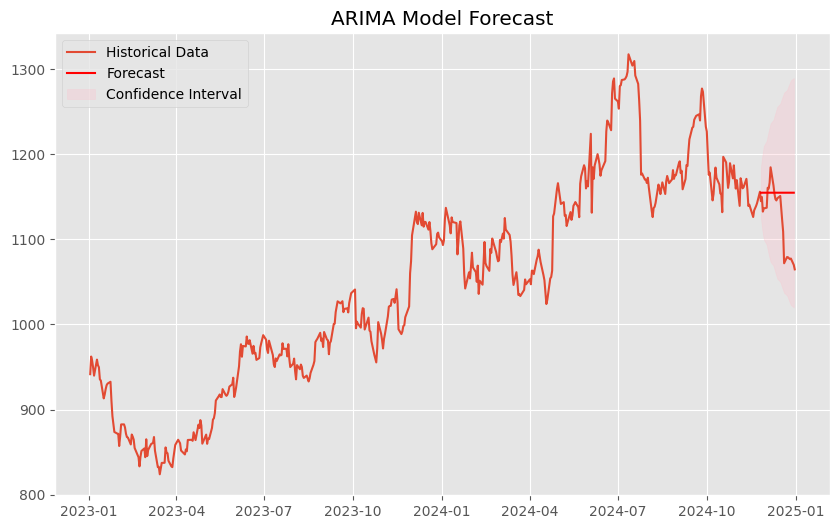

In [415]:




data=axis.Close[:470]       



p, d, q =1,1,0  # Replace with values from ACF and PACF plots if needed
model = ARIMA(data, order=(p, d, q))
model_fit = model.fit()


print(model_fit.summary())

#Forecast
forecast_steps = 25  # Predict next 30 time points
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=data.index[-1], periods=forecast_steps + 1, freq="B")[1:]
forecast_series = forecast.predicted_mean
forecast_ci = forecast.conf_int()

#Plot results
plt.figure(figsize=(10, 6))
plt.plot(axis.Close[:495], label="Historical Data")
plt.plot(forecast_index, forecast_series, label="Forecast", color="red")
plt.fill_between(forecast_index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], 
                 color='pink', alpha=0.3, label="Confidence Interval")
plt.legend()
plt.title("ARIMA Model Forecast")
plt.show()


**Looking for a parameter**

In [416]:
#pip install pmdarima
from pmdarima import auto_arima
auto_model = auto_arima(data, seasonal=False, trace=True)
print(auto_model.order)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3868.909, Time=1.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3878.674, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3876.341, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3877.201, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3877.106, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3869.950, Time=0.50 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3870.918, Time=0.58 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3863.682, Time=1.31 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3870.278, Time=0.48 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3862.487, Time=2.27 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=3870.096, Time=1.26 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.25 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=3867.681, Time=2.28 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3862.512, Time=2.17 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : 

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  470
Model:                 ARIMA(4, 1, 2)   Log Likelihood               -1923.370
Date:                Sun, 02 Feb 2025   AIC                           3860.740
Time:                        22:38:11   BIC                           3889.795
Sample:                             0   HQIC                          3872.172
                                - 470                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5860      0.064      9.116      0.000       0.460       0.712
ar.L2         -0.6960      0.065    -10.690      0.000      -0.824      -0.568
ar.L3         -0.2306      0.046     -4.985      0.0

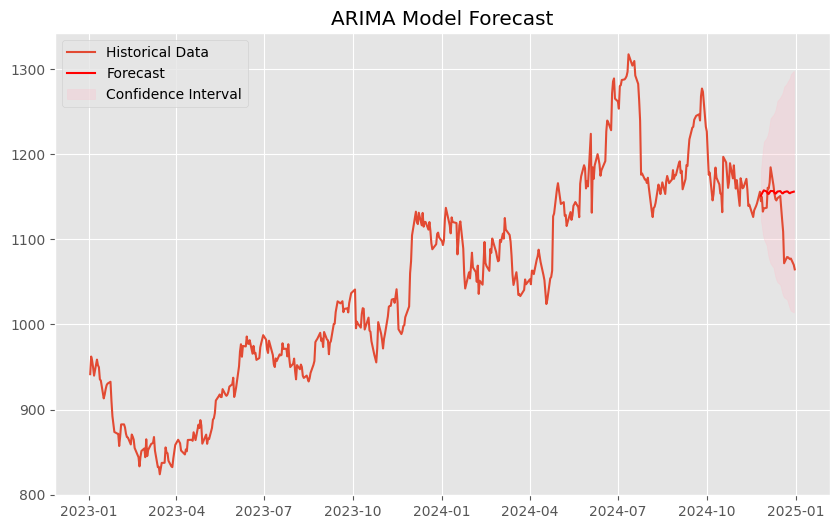

In [417]:



data=axis.Close[:470]       



p, d, q =4,1,2  
model = ARIMA(data, order=(p, d, q))
model_fit = model.fit()


print(model_fit.summary())

# Step 6: Forecast
forecast_steps = 25  
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=data.index[-1], periods=forecast_steps + 1, freq="B")[1:]
forecast_series = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(axis.Close[:495], label="Historical Data")
plt.plot(forecast_index, forecast_series, label="Forecast", color="red")
plt.fill_between(forecast_index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], 
                 color='pink', alpha=0.3, label="Confidence Interval")
plt.legend()
plt.title("ARIMA Model Forecast")
plt.show()


In [418]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(axis.Close[470:], forecast_series)
print("Mean Absolute Error:", mae)

mse = mean_squared_error(axis.Close[470:], forecast_series)
rmse = np.sqrt(mse)
print("Root Mean Absolute Error:",rmse)



mape = np.mean(np.abs((np.array(forecast_series) - np.array(axis.Close[470:])) / axis.Close[470:])) * 100
print("Mean Absolute Percentage Error:",mape)



Mean Absolute Error: 33.07325439260945
Root Mean Absolute Error: 45.78922003428441
Mean Absolute Percentage Error: 3.024845376861656


`SARIMA` 

In [419]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
order = (4, 1, 2)             
seasonal_order = (1, 1, 1, 14)  
order = (1, 1, 1)             

model = SARIMAX(data, order=order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)

# Step 6: Model Summary
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  470
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 14)   Log Likelihood               -1894.743
Date:                            Sun, 02 Feb 2025   AIC                           3799.486
Time:                                    22:38:14   BIC                           3820.087
Sample:                                         0   HQIC                          3807.602
                                            - 470                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6570      0.224     -2.937      0.003      -1.095      -0.219
ma.L1          0.5501      0.241   

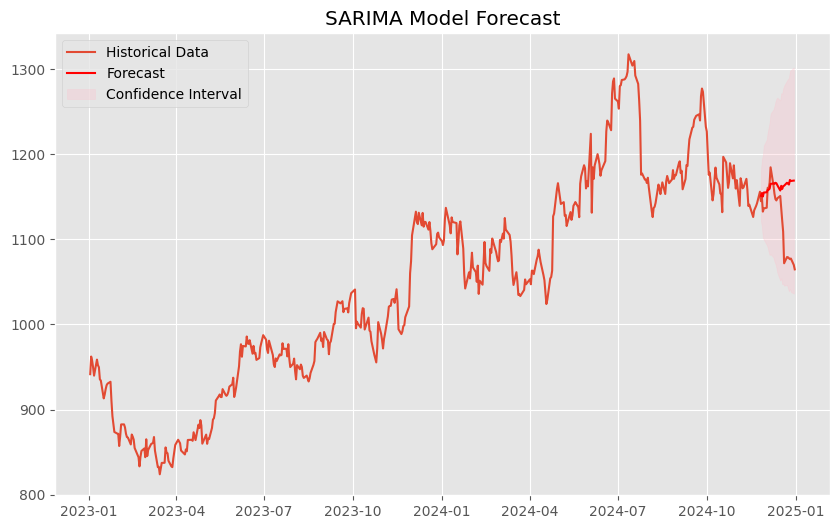

In [420]:
forecast_steps = 25  # Predict next 30 time points
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=data.index[-1], periods=forecast_steps + 1, freq="B")[1:]
forecast_series = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Step 7: Plot results
plt.figure(figsize=(10, 6))
plt.plot(axis.Close[:495], label="Historical Data")
plt.plot(forecast_index, forecast_series, label="Forecast", color="red")
plt.fill_between(forecast_index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], 
                 color='pink', alpha=0.3, label="Confidence Interval")
plt.legend()
plt.title("SARIMA Model Forecast")
plt.show()


In [421]:

mae = mean_absolute_error(axis.Close[470:], forecast_series)
print("Mean Absolute Error:", mae)

mse = mean_squared_error(axis.Close[470:], forecast_series)
rmse = np.sqrt(mse)
print("Root Mean Absolute Error:",rmse)



mape = np.mean(np.abs((np.array(forecast_series) - np.array(axis.Close[470:])) / axis.Close[470:])) * 100
print("Mean Absolute Percentage Error:",mape)



Mean Absolute Error: 37.38042595900006
Root Mean Absolute Error: 52.053777069655325
Mean Absolute Percentage Error: 3.4219506851357537


**Lets try some other split for train and forecast as we can see in our earlier split its difficult to forecast**

In [422]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
order = (4, 1, 2)             
seasonal_order = (1, 1, 1, 14)  
order = (1, 1, 1)             

model = SARIMAX(data[:440], order=order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)

# Step 6: Model Summary
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  440
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 14)   Log Likelihood               -1765.750
Date:                            Sun, 02 Feb 2025   AIC                           3541.499
Time:                                    22:38:19   BIC                           3561.759
Sample:                                         0   HQIC                          3549.503
                                            - 440                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6869      0.225     -3.052      0.002      -1.128      -0.246
ma.L1          0.5875      0.242   

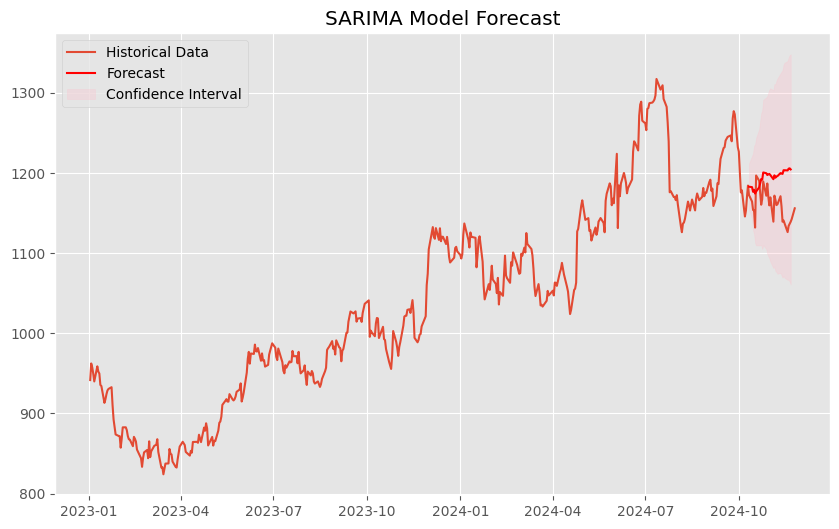

In [423]:
forecast_steps = 30  # Predict next 30 time points
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=data[:440].index[-1], periods=forecast_steps + 1, freq="B")[1:]
forecast_series = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Step 7: Plot results
plt.figure(figsize=(10, 6))
plt.plot(data, label="Historical Data")
plt.plot(forecast_index, forecast_series, label="Forecast", color="red")
plt.fill_between(forecast_index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], 
                 color='pink', alpha=0.3, label="Confidence Interval")
plt.legend()
plt.title("SARIMA Model Forecast")
plt.show()


In [424]:

mae = mean_absolute_error(data[440:], forecast_series)
print("Mean Absolute Error:", mae)

mse = mean_squared_error(data[440:], forecast_series)
rmse = np.sqrt(mse)
print("Root Mean Absolute Error:",rmse)



mape = np.mean(np.abs((np.array(forecast_series) - np.array(data[440:])) / data[440:])) * 100
print("Mean Absolute Percentage Error:",mape)



Mean Absolute Error: 35.12504663900749
Root Mean Absolute Error: 39.99605115934155
Mean Absolute Percentage Error: 3.049575239201013


**`Prophet Model`**

In [425]:
from prophet import Prophet

In [426]:
data = pd.DataFrame(data)
data["ds"] = data.index
data.columns  =["y","ds"]
data.reset_index(inplace = True)
data.drop("Date",inplace=True,axis = 1)

In [427]:
data = data[:470]


In [428]:
data.tail()

,y,ds
465,1126.20,2024-11-18
466,1133.95,2024-11-19
467,1139.15,2024-11-21
468,1142.40,2024-11-22
469,1155.90,2024-11-25


In [429]:
model = Prophet(daily_seasonality=True)  # You can set seasonalities like weekly, yearly, etc.
model.fit(data)

future = model.make_future_dataframe(periods=25)


forecast  = model.predict(future)


22:38:20 - cmdstanpy - INFO - Chain [1] start processing
22:38:20 - cmdstanpy - INFO - Chain [1] done processing


In [430]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-01-02,936.770232,886.147663,967.123194,936.770232,936.770232,-9.435109,-9.435109,-9.435109,-9.704075,-9.704075,-9.704075,0.268965,0.268965,0.268965,0.0,0.0,0.0,927.335122
1,2023-01-03,935.596362,888.518874,967.754191,935.596362,935.596362,-9.448178,-9.448178,-9.448178,-9.704075,-9.704075,-9.704075,0.255897,0.255897,0.255897,0.0,0.0,0.0,926.148184
2,2023-01-04,934.422491,884.409110,962.388617,934.422491,934.422491,-11.774883,-11.774883,-11.774883,-9.704075,-9.704075,-9.704075,-2.070808,-2.070808,-2.070808,0.0,0.0,0.0,922.647609
3,2023-01-05,933.248621,889.081695,960.748762,933.248621,933.248621,-10.815823,-10.815823,-10.815823,-9.704075,-9.704075,-9.704075,-1.111749,-1.111749,-1.111749,0.0,0.0,0.0,922.432798
4,2023-01-06,932.074751,880.937234,962.669785,932.074751,932.074751,-8.972193,-8.972193,-8.972193,-9.704075,-9.704075,-9.704075,0.731882,0.731882,0.731882,0.0,0.0,0.0,923.102558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,2024-12-16,1150.757480,1100.780605,1178.002835,1147.195766,1155.478225,-9.435109,-9.435109,-9.435109,-9.704075,-9.704075,-9.704075,0.268965,0.268965,0.268965,0.0,0.0,0.0,1141.322371
491,2024-12-17,1150.198516,1100.125122,1181.026954,1146.233918,1155.387167,-9.448178,-9.448178,-9.448178,-9.704075,-9.704075,-9.704075,0.255897,0.255897,0.255897,0.0,0.0,0.0,1140.750338
492,2024-12-18,1149.639551,1097.931242,1180.129481,1145.316229,1155.231679,-11.774883,-11.774883,-11.774883,-9.704075,-9.704075,-9.704075,-2.070808,-2.070808,-2.070808,0.0,0.0,0.0,1137.864669
493,2024-12-19,1149.080587,1098.672122,1176.910624,1144.348490,1155.223453,-10.815823,-10.815823,-10.815823,-9.704075,-9.704075,-9.704075,-1.111749,-1.111749,-1.111749,0.0,0.0,0.0,1138.264763


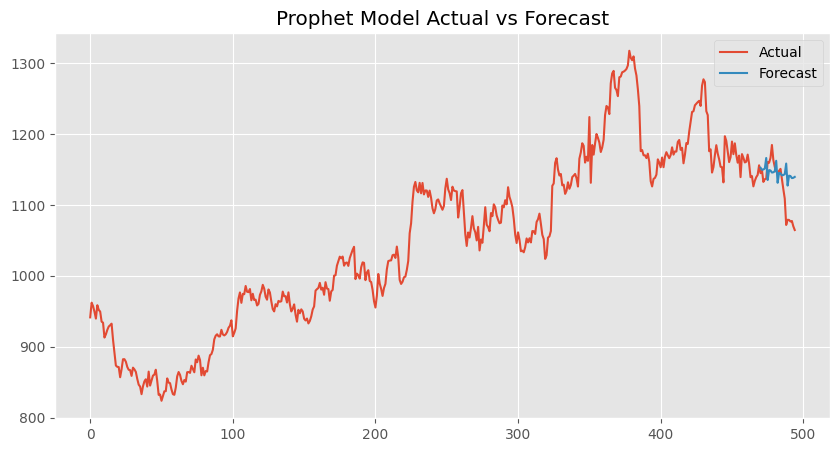

In [431]:
plt.figure(figsize = (10,5))
plt.plot(axis.Close.reset_index(drop = True), label = 'Actual')
plt.plot(forecast.yhat[470:], label = "Forecast")
plt.title("Prophet Model Actual vs Forecast")
#plt.fill_between(forecast.yhat[1300:],forecast.yhat_lower[1300:],forecast.yhat_upper[1300:],
                 #color='blue', alpha=0.3, label="Confidence Interval")
plt.legend()
plt.show()

In [432]:
mae = mean_absolute_error(axis.Close[470:], forecast.yhat[470:])
print("Mean Absolute Error:", mae)

mse = mean_squared_error(axis.Close[470:], forecast.yhat[470:])
rmse = np.sqrt(mse)
print("Root Mean Absolute Error:",rmse)



mape = np.mean(np.abs((np.array(forecast.yhat[470:]) - np.array(axis.Close[470:])) / axis.Close[470:])) * 100
print("Mean Absolute Percentage Error:",mape)

Mean Absolute Error: 29.936502070580964
Root Mean Absolute Error: 39.07622667290707
Mean Absolute Percentage Error: 2.7212842366881627


**Hyperparamter Tuning**

22:38:21 - cmdstanpy - INFO - Chain [1] start processing
22:38:21 - cmdstanpy - INFO - Chain [1] done processing


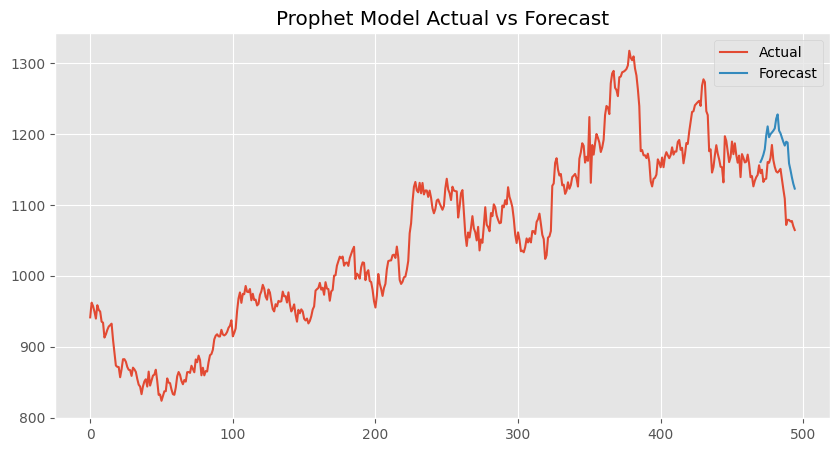

In [433]:
model = Prophet(daily_seasonality=True,n_changepoints=10,seasonality_mode="additive",
               yearly_seasonality = 14, changepoint_prior_scale = 20)
model.fit(data)

future = model.make_future_dataframe(periods=25)


forecast  = model.predict(future)



plt.figure(figsize = (10,5))
plt.plot(axis.Close.reset_index(drop = True), label = 'Actual')
plt.plot(forecast.yhat[470:], label = "Forecast")
plt.title("Prophet Model Actual vs Forecast")
#plt.fill_between(forecast.yhat[1300:],forecast.yhat_lower[1300:],forecast.yhat_upper[1300:],
                 #color='blue', alpha=0.3, label="Confidence Interval")
plt.legend()
plt.show()

In [434]:
mae = mean_absolute_error(axis.Close[470:], forecast.yhat[470:])
print("Mean Absolute Error:", mae)

mse = mean_squared_error(axis.Close[470:], forecast.yhat[470:])
rmse = np.sqrt(mse)
print("Root Mean Absolute Error:",rmse)



mape = np.mean(np.abs((np.array(forecast.yhat[470:]) - np.array(axis.Close[470:])) / axis.Close[470:])) * 100
print("Mean Absolute Percentage Error:",mape)

Mean Absolute Error: 57.0830824227651
Root Mean Absolute Error: 62.228615136061265
Mean Absolute Percentage Error: 5.118023920163368


**Hyperaparamter tuning using Optuna**

In [435]:
#!pip install optuna

In [436]:
import optuna





def objective(trial):
    
    changepoint_prior_scale = trial.suggest_loguniform("changepoint_prior_scale", 0.01, 4)
    seasonality_prior_scale = trial.suggest_loguniform("seasonality_prior_scale", 0.01, 20)
    holidays_prior_scale = trial.suggest_loguniform("holidays_prior_scale", 0.01, 10)
    yearly_seasonality  = trial.suggest_loguniform("yearly_seasonality", 2,20)
    n_changepoints = trial.suggest_uniform("n_changepoints", 1,20)
    seasonality_mode = trial.suggest_categorical("seasonality_mode", ["additive", "multiplicative"])

    
    model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale=holidays_prior_scale,
        
        yearly_seasonality = yearly_seasonality,
        seasonality_mode=seasonality_mode
    )

    
    model.fit(data)

   
    future = model.make_future_dataframe(periods=25)
    forecast = model.predict(future)

    
    y_true = axis.Close[470:].values  
    y_pred = forecast["yhat"][470:].values 
    return mean_absolute_error(y_true, y_pred)


study = optuna.create_study(direction="minimize")  
study.optimize(objective, n_trials=50) 

print(study.best_params)


[I 2025-02-02 22:38:22,060] A new study created in memory with name: no-name-fa3721cc-2443-4d43-b9bd-0416ee4b24a8
22:38:22 - cmdstanpy - INFO - Chain [1] start processing
22:38:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-02-02 22:38:22,551] Trial 0 finished with value: 100.85469311094351 and parameters: {'changepoint_prior_scale': 0.019025487259047732, 'seasonality_prior_scale': 0.2300006899018151, 'holidays_prior_scale': 0.011998509433980226, 'yearly_seasonality': 8.015867650380313, 'n_changepoints': 2.7128426659633336, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 100.85469311094351.
22:38:22 - cmdstanpy - INFO - Chain [1] start processing
22:38:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-02-02 22:38:23,133] Trial 1 finished with value: 54.46684537056387 and parameters: {'changepoint_prior_scale': 0.20585749596821012, 'seasonality_prior_scale': 0.27364990640069314, 'holidays_prior_scale': 0.0113180387048057, 'yearly_seasonality': 4.128825450

{'changepoint_prior_scale': 0.13180943358612532, 'seasonality_prior_scale': 0.012645328951332016, 'holidays_prior_scale': 2.0469396026963373, 'yearly_seasonality': 2.620879006146226, 'n_changepoints': 9.650102638312347, 'seasonality_mode': 'additive'}


22:38:52 - cmdstanpy - INFO - Chain [1] start processing
22:38:53 - cmdstanpy - INFO - Chain [1] done processing


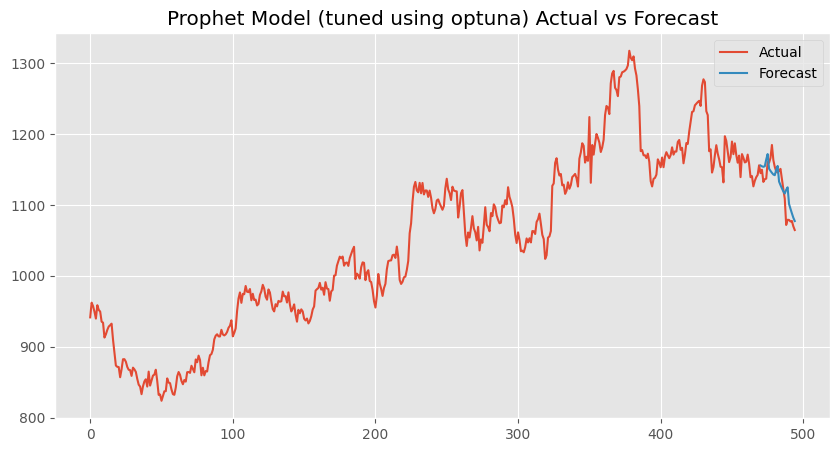

In [437]:
model = Prophet(changepoint_prior_scale = 0.70, seasonality_prior_scale =  2.611, holidays_prior_scale = 6.6, 
                seasonality_mode = "multiplicative", yearly_seasonality = 5.74)
model.fit(data)

future = model.make_future_dataframe(periods=25)


forecast  = model.predict(future)



plt.figure(figsize = (10,5))
plt.plot(axis.Close.reset_index(drop = True), label = 'Actual')
plt.plot(forecast.yhat[470:], label = "Forecast")
plt.title("Prophet Model (tuned using optuna) Actual vs Forecast")

plt.legend()
plt.show()

In [438]:
mae = mean_absolute_error(axis.Close[470:], forecast.yhat[470:])
print("Mean Absolute Error:", mae)

mse = mean_squared_error(axis.Close[470:], forecast.yhat[470:])
rmse = np.sqrt(mse)
print("Root Mean Absolute Error:",rmse)



mape = np.mean(np.abs((np.array(forecast.yhat[470:]) - np.array(axis.Close[470:])) / axis.Close[470:])) * 100
print("Mean Absolute Percentage Error:",mape)

Mean Absolute Error: 17.427886820493022
Root Mean Absolute Error: 21.126550372714444
Mean Absolute Percentage Error: 1.5557750146503897


**Model components**

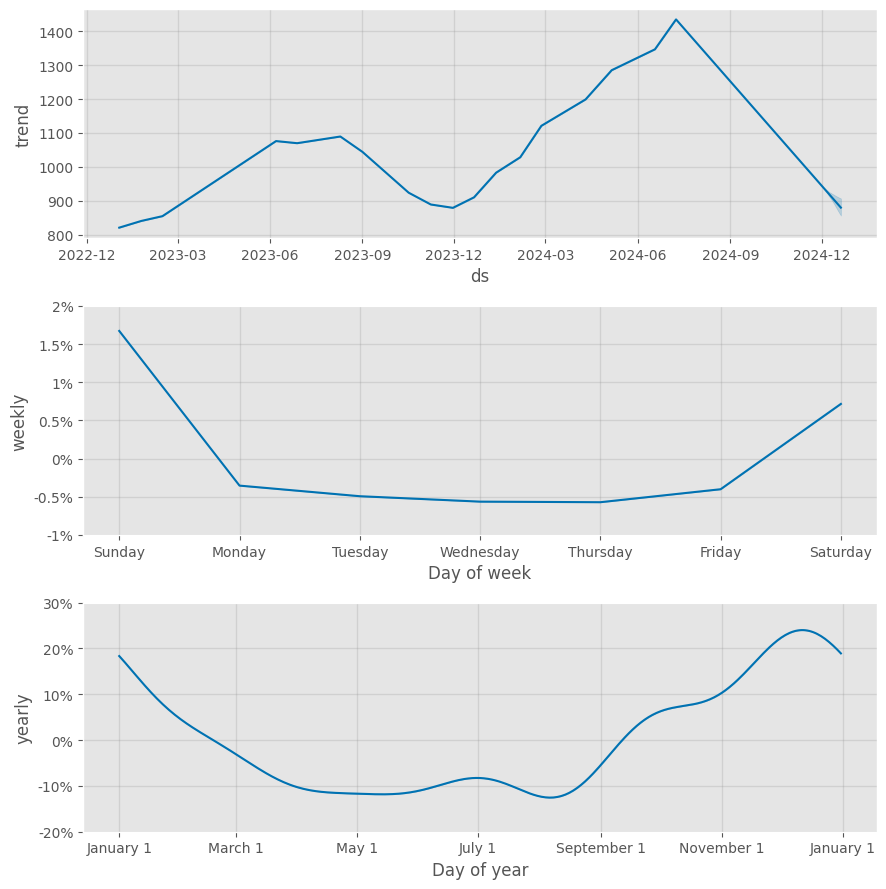

In [439]:
model.plot_components(forecast)
plt.show()

## **Model Diagnostic**

In [440]:
from prophet.diagnostics import cross_validation, performance_metrics

# Perform cross-validation
df_cv = cross_validation(model, 
                         initial='250 days',   # First training set = 1 year
                         period='50 days',    # Move forward every 50 days
                         horizon='20 days')    # Forecast 20 days ahead

# Compute performance metrics
df_p = performance_metrics(df_cv)
print(df_p[['horizon', 'rmse', 'mape']])


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/9 [00:00<?, ?it/s]

22:38:54 - cmdstanpy - INFO - Chain [1] start processing
22:38:54 - cmdstanpy - INFO - Chain [1] done processing
22:38:55 - cmdstanpy - INFO - Chain [1] start processing
22:38:55 - cmdstanpy - INFO - Chain [1] done processing
22:38:55 - cmdstanpy - INFO - Chain [1] start processing
22:38:55 - cmdstanpy - INFO - Chain [1] done processing
22:38:56 - cmdstanpy - INFO - Chain [1] start processing
22:38:56 - cmdstanpy - INFO - Chain [1] done processing
22:38:56 - cmdstanpy - INFO - Chain [1] start processing
22:38:56 - cmdstanpy - INFO - Chain [1] done processing
22:38:56 - cmdstanpy - INFO - Chain [1] start processing
22:38:57 - cmdstanpy - INFO - Chain [1] done processing
22:38:57 - cmdstanpy - INFO - Chain [1] start processing
22:38:57 - cmdstanpy - INFO - Chain [1] done processing
22:38:57 - cmdstanpy - INFO - Chain [1] start processing
22:38:58 - cmdstanpy - INFO - Chain [1] done processing
22:38:58 - cmdstanpy - INFO - Chain [1] start processing
22:38:58 - cmdstanpy - INFO - Chain [1]

   horizon         rmse      mape
0   2 days    26.336726  0.018304
1   3 days    26.743578  0.019900
2   4 days    25.029323  0.017267
3   5 days    21.678647  0.013668
4   6 days    27.137221  0.015862
5   7 days    41.883055  0.029806
6   8 days    50.712691  0.039834
7   9 days    58.172735  0.046349
8  10 days  1703.907167  0.485853
9  11 days  1577.694189  0.422288
10 12 days  1116.175554  0.229816
11 13 days    80.546227  0.058687
12 14 days   105.646748  0.084249
13 15 days   108.756738  0.085828
14 16 days   114.271299  0.088028
15 17 days   120.455885  0.092271
16 18 days   112.496292  0.089208
17 19 days   100.006845  0.082031
18 20 days   116.662400  0.094109


In [441]:
df_cv[:50]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2023-10-03,1040.764719,1029.821107,1052.161154,1041.05,2023-10-02
1,2023-10-04,1043.722626,1031.770574,1055.280269,995.55,2023-10-02
2,2023-10-05,1045.191252,1033.673324,1056.912036,1003.25,2023-10-02
3,2023-10-06,1052.247341,1039.570597,1063.026434,1000.95,2023-10-02
4,2023-10-09,1064.505397,1051.701804,1076.535204,996.25,2023-10-02
5,2023-10-10,1068.896962,1055.286393,1082.849891,1012.25,2023-10-02
6,2023-10-11,1074.359028,1061.036594,1088.628778,1019.10,2023-10-02
7,2023-10-12,1078.401338,1063.778551,1093.081943,1018.45,2023-10-02
8,2023-10-13,1088.408467,1071.856603,1105.336827,994.05,2023-10-02
9,2023-10-16,1109.800590,1092.477510,1128.955098,1004.80,2023-10-02


**Lets train it for first one year**

**`Lets try to train 365 days and then try to forecast for 25 days`**

22:38:58 - cmdstanpy - INFO - Chain [1] start processing
22:38:59 - cmdstanpy - INFO - Chain [1] done processing


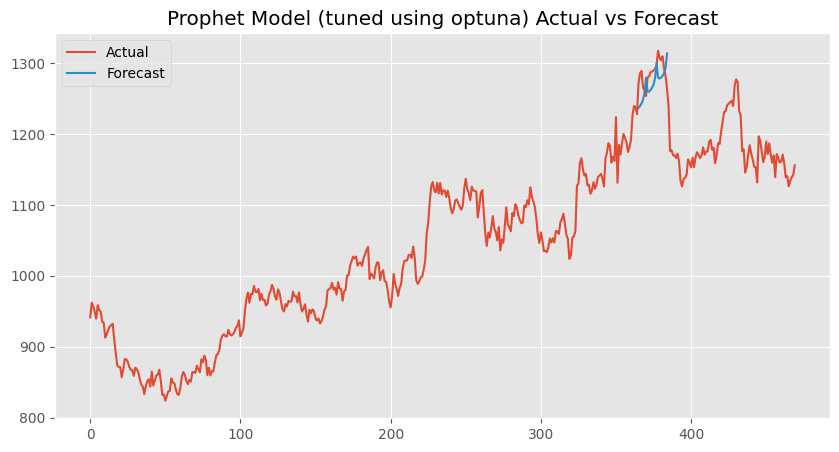

In [442]:
model = Prophet(changepoint_prior_scale = 0.70, seasonality_prior_scale =  2.611, holidays_prior_scale = 6.6, 
                seasonality_mode = "multiplicative", yearly_seasonality = 5.74)
model.fit(data[:365])

future = model.make_future_dataframe(periods=20)


forecast  = model.predict(future)



plt.figure(figsize = (10,5))
plt.plot(data.reset_index(drop = True).y, label = 'Actual')
plt.plot(forecast.yhat[365:], label = "Forecast")
plt.title("Prophet Model (tuned using optuna) Actual vs Forecast")

plt.legend()
plt.show()

22:38:59 - cmdstanpy - INFO - Chain [1] start processing
22:39:00 - cmdstanpy - INFO - Chain [1] done processing


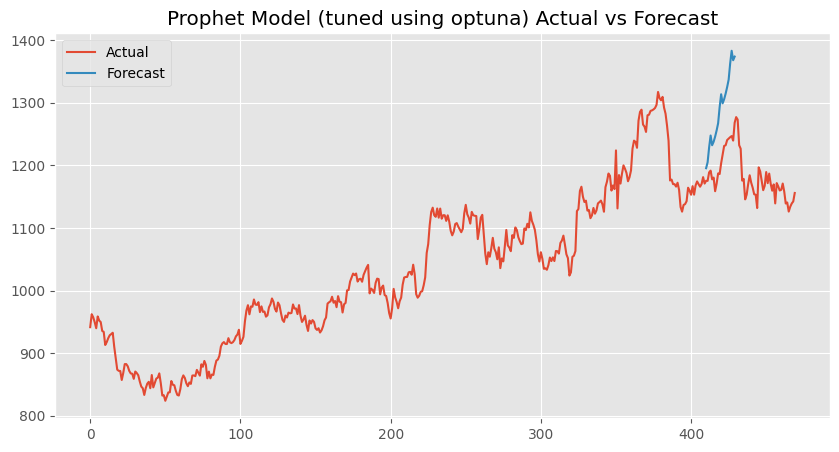

In [443]:
model = Prophet(changepoint_prior_scale = 0.70, seasonality_prior_scale =  2.611, holidays_prior_scale = 6.6, 
                seasonality_mode = "multiplicative", yearly_seasonality = 5.74)
model.fit(data[:410])

future = model.make_future_dataframe(periods=20)


forecast  = model.predict(future)



plt.figure(figsize = (10,5))
plt.plot(data.reset_index(drop = True).y, label = 'Actual')
plt.plot(forecast.yhat[410:], label = "Forecast")
plt.title("Prophet Model (tuned using optuna) Actual vs Forecast")

plt.legend()
plt.show()

**Lets slightly change parameter changepoint_prior_scale**

22:39:00 - cmdstanpy - INFO - Chain [1] start processing
22:39:00 - cmdstanpy - INFO - Chain [1] done processing


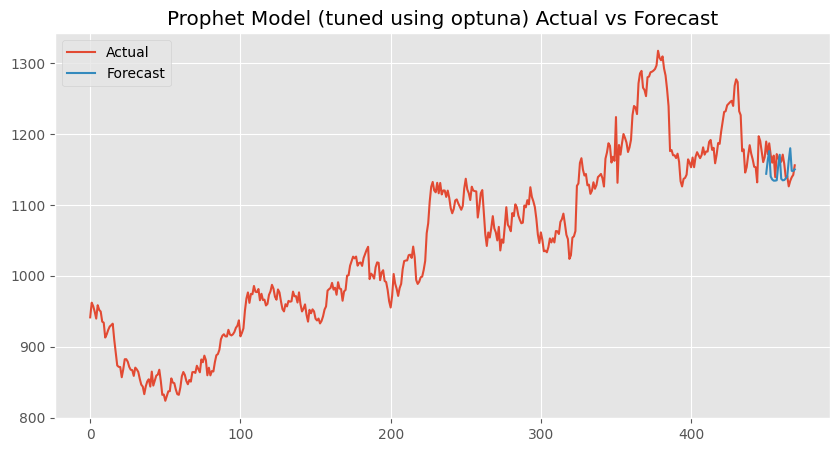

In [444]:
model = Prophet(changepoint_prior_scale = 0.05, seasonality_prior_scale =  2.611, holidays_prior_scale = 6.6, 
                seasonality_mode = "multiplicative", yearly_seasonality = 5.74)
model.fit(data[:450])

future = model.make_future_dataframe(periods=20)


forecast  = model.predict(future)



plt.figure(figsize = (10,5))
plt.plot(data.reset_index(drop = True).y, label = 'Actual')
plt.plot(forecast.yhat[450:], label = "Forecast")
plt.title("Prophet Model (tuned using optuna) Actual vs Forecast")

plt.legend()
plt.show()

22:39:01 - cmdstanpy - INFO - Chain [1] start processing
22:39:01 - cmdstanpy - INFO - Chain [1] done processing


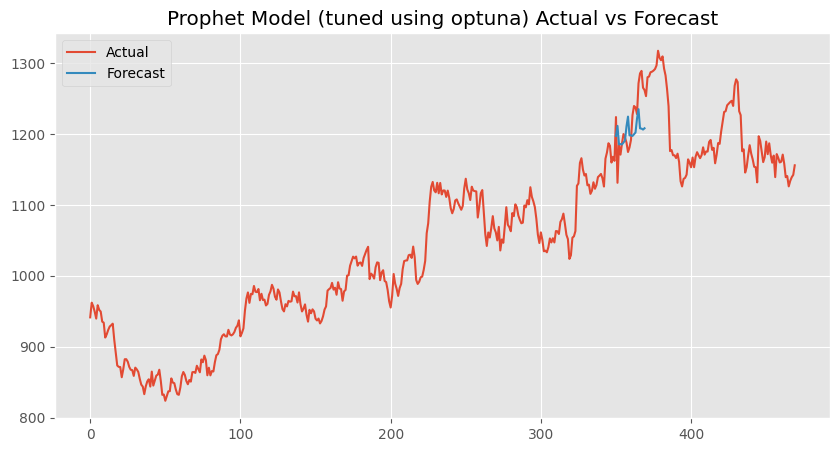

In [445]:
model = Prophet(changepoint_prior_scale = 0.05, seasonality_prior_scale =  2.611, holidays_prior_scale = 6.6, 
                seasonality_mode = "multiplicative", yearly_seasonality = 5.74)
model.fit(data[:350])

future = model.make_future_dataframe(periods=20)


forecast  = model.predict(future)



plt.figure(figsize = (10,5))
plt.plot(data.reset_index(drop = True).y, label = 'Actual')
plt.plot(forecast.yhat[350:], label = "Forecast")
plt.title("Prophet Model (tuned using optuna) Actual vs Forecast")

plt.legend()
plt.show()

22:39:02 - cmdstanpy - INFO - Chain [1] start processing
22:39:02 - cmdstanpy - INFO - Chain [1] done processing


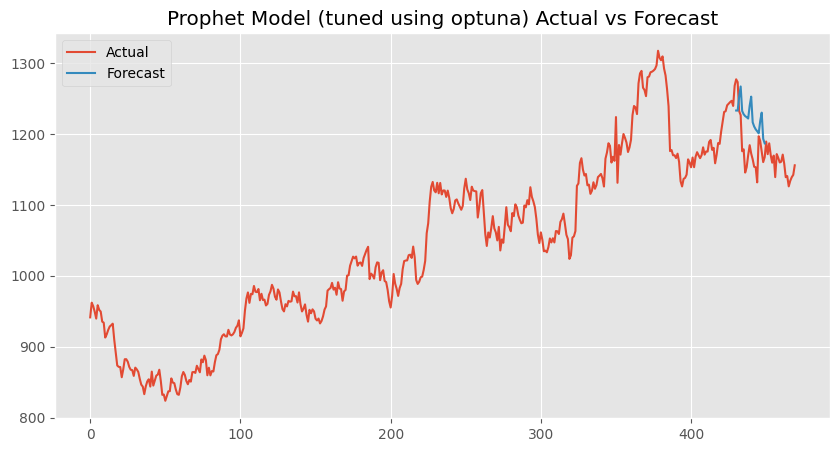

In [446]:
model = Prophet(changepoint_prior_scale = 0.05, seasonality_prior_scale =  2.611, holidays_prior_scale = 6.6, 
                seasonality_mode = "multiplicative", yearly_seasonality = 5.74)
model.fit(data[:430])

future = model.make_future_dataframe(periods=20)


forecast  = model.predict(future)



plt.figure(figsize = (10,5))
plt.plot(data.reset_index(drop = True).y, label = 'Actual')
plt.plot(forecast.yhat[430:], label = "Forecast")
plt.title("Prophet Model (tuned using optuna) Actual vs Forecast")

plt.legend()
plt.show()

In [447]:
from prophet.diagnostics import cross_validation, performance_metrics

# Perform cross-validation
df_cv = cross_validation(model, 
                         initial='300 days',   # First training set = 1 year
                         period='30 days',    # Move forward every 50 days
                         horizon='20 days')    # Forecast 20 days ahead

# Compute performance metrics
df_p = performance_metrics(df_cv)
print(df_p[['horizon', 'rmse', 'mape']])


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/11 [00:00<?, ?it/s]

22:39:02 - cmdstanpy - INFO - Chain [1] start processing
22:39:02 - cmdstanpy - INFO - Chain [1] done processing
22:39:03 - cmdstanpy - INFO - Chain [1] start processing
22:39:03 - cmdstanpy - INFO - Chain [1] done processing
22:39:03 - cmdstanpy - INFO - Chain [1] start processing
22:39:03 - cmdstanpy - INFO - Chain [1] done processing
22:39:03 - cmdstanpy - INFO - Chain [1] start processing
22:39:03 - cmdstanpy - INFO - Chain [1] done processing
22:39:03 - cmdstanpy - INFO - Chain [1] start processing
22:39:04 - cmdstanpy - INFO - Chain [1] done processing
22:39:04 - cmdstanpy - INFO - Chain [1] start processing
22:39:04 - cmdstanpy - INFO - Chain [1] done processing
22:39:04 - cmdstanpy - INFO - Chain [1] start processing
22:39:04 - cmdstanpy - INFO - Chain [1] done processing
22:39:04 - cmdstanpy - INFO - Chain [1] start processing
22:39:04 - cmdstanpy - INFO - Chain [1] done processing
22:39:05 - cmdstanpy - INFO - Chain [1] start processing
22:39:05 - cmdstanpy - INFO - Chain [1]

   horizon       rmse      mape
0   2 days  33.217293  0.025209
1   3 days  32.557687  0.024478
2   4 days  28.085512  0.020124
3   5 days  32.869936  0.023446
4   6 days  39.396445  0.031395
5   7 days  39.182966  0.031470
6   8 days  35.241813  0.026556
7   9 days  38.727409  0.029923
8  10 days  53.824822  0.044299
9  11 days  61.666670  0.048147
10 12 days  65.321264  0.050265
11 13 days  67.409813  0.053635
12 14 days  61.042026  0.046591
13 15 days  47.285536  0.033456
14 16 days  38.873875  0.025739
15 17 days  45.096941  0.030422
16 18 days  66.608069  0.050755
17 19 days  72.343611  0.056804
18 20 days  64.602382  0.048857


###  Prophet Model Comparison

**We have seen two models of prophet as per now, with slightly different parameter i.e n_changepoints**

- **`First Model`** : changepoint_prior_scale = 0.70, seasonality_prior_scale =  2.611, holidays_prior_scale = 6.6, 
                seasonality_mode = "multiplicative", yearly_seasonality = 5.74
                
> This model seems to perform very well on certain points as we have seen in our first case but in certain case it is performing very worst

- **`Second Model`** : changepoint_prior_scale = 0.05, seasonality_prior_scale =  2.611, holidays_prior_scale = 6.6, 
                seasonality_mode = "multiplicative", yearly_seasonality = 5.74
> Second model although is not fitting as perfect as our first model but it is consistent through most of the splits

# Machine Learning and Hybrid Models

### `XGBoost Model`

In [448]:
import xgboost as xgb


In [449]:
df = axis.Close
df = pd.DataFrame(df)
df.columns = ["y"]

df["lag_1"] = df["y"].shift(1)
df["lag_2"] = df["y"].shift(2)
df["lag_3"] = df["y"].shift(3)


df["rolling_mean_5"] = df["y"].rolling(window=5).mean()
df["rolling_std_5"] = df["y"].rolling(window=5).std()


df["dayofweek"] = df.index.dayofweek  # Monday = 0, Sunday = 6
df["month"] = df.index.month

# Drop NaN values (due to shifting)
df.dropna(inplace=True)

In [450]:
X = df.drop(columns=["y"])
y = df["y"]

In [451]:
train_size = 470
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [452]:
model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=4, objective="reg:squarederror")

# Train model
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [453]:
last_row = X_train.iloc[-1].copy()

future_preds = []
for _ in range(21):  # Predict next 20 days
    # Predict next value
    pred = model.predict(last_row.values.reshape(1, -1))[0]
    
    # Store prediction
    future_preds.append(pred)

    # Update lag features dynamically
    last_row["lag_3"] = last_row["lag_2"]
    last_row["lag_2"] = last_row["lag_1"]
    last_row["lag_1"] = pred

    # Update moving average (rolling window)
    last_row["rolling_mean_5"] = np.mean([last_row["lag_1"], last_row["lag_2"], last_row["lag_3"]])
    last_row["rolling_std_5"] = np.std([last_row["lag_1"], last_row["lag_2"], last_row["lag_3"]])

# Print forecasted prices
print(future_preds)

[1138.0604, 1142.6957, 1145.192, 1148.1444, 1144.8986, 1140.0735, 1140.0735, 1140.4106, 1140.5503, 1140.5503, 1140.5503, 1140.5503, 1140.5503, 1140.5503, 1140.5503, 1140.5503, 1140.5503, 1140.5503, 1140.5503, 1140.5503, 1140.5503]


In [454]:
y_test

Date
2024-12-02    1137.10
2024-12-03    1160.50
2024-12-04    1159.45
2024-12-05    1166.40
2024-12-06    1184.55
2024-12-09    1163.25
2024-12-10    1153.65
2024-12-11    1147.25
2024-12-12    1145.65
2024-12-13    1148.15
2024-12-16    1150.90
2024-12-17    1136.25
2024-12-18    1122.25
2024-12-19    1108.90
2024-12-20    1071.85
2024-12-23    1079.15
2024-12-24    1078.90
2024-12-26    1076.70
2024-12-27    1077.45
2024-12-30    1069.95
2024-12-31    1064.70
Name: y, dtype: float64

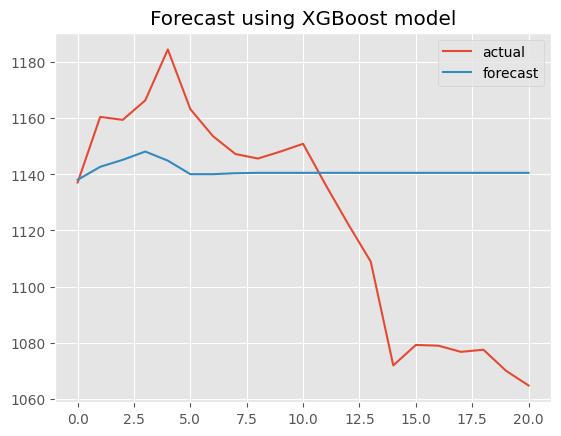

In [455]:
plt.plot(np.array(y_test), label= "actual")
plt.plot(future_preds,label = "forecast")
plt.title("Forecast using XGBoost model")
plt.legend()
plt.show()

`It is giving very poor performance`